In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/texturemodel/code/'
sys.path.insert(0,codepath)

from plotting import plot_utils, summary_plots, load_fits, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils

#### Load model fits

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

# different fit files for each value of sigma
sigmas = np.array([0.020, 0.031, 0.048, 0.074, 0.114, 0.176, 0.271, 0.419, 0.647, 1.000])
n_sigmas = len(sigmas)+1

sig_names = ['fixed sigma=%.3f'%sig for sig in sigmas]
sig_names += ['let sigma vary freely'] # the "vary freely" model is the normal one from main analyses

fitting_types = ['texture_pyramid_ridge_4ori_4sf_pcaHL_use_texture_fixsigma%.3f_pRFs'%sig for sig in sigmas]
fitting_types += ['texture_pyramid_ridge_4ori_4sf_pcaHL_use_texture_pRFs']

out = [[load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False) \
       for ss in subjects] for fitting_type in fitting_types]


nc_thresh = 0.01
r2_thresh = 0.01 
# we did not do the full permutation test for each sigma value, so just using an R2 threshold as a 
# way of selecting reasonably good fits. 

#### Make ROI definitions

In [3]:
subjects = np.arange(1,9)
roi_def = roi_utils.multi_subject_roi_def(subjects, areas_include = ['V1','V2','V3','hV4', \
                                                      'OPA','PPA','RSC',\
                                                      'FFA','EBA'], use_kastner_areas=False, \
                                         remove_ret_overlap=True, remove_categ_overlap=True)
roi_names = roi_def.roi_names;
n_rois = len(roi_names)

In [4]:
# double check that my sigma restriction worked right

for sig_ind in range(n_sigmas):
    if sig_ind<n_sigmas-1:
        print(sigmas[sig_ind])
    else:
        print('all')
    best_sigmas = np.concatenate([out[sig_ind][si]['best_params'][0][:,0,2] for si in range(n_subjects)], axis=0)
    print(np.unique(best_sigmas))
    

0.02
[0.02]
0.031
[0.03088904]
0.048
[0.04770664]
0.074
[0.07368063]
0.114
[0.1137962]
0.176
[0.17575279]
0.271
[0.27144176]
0.419
[0.4192288]
0.647
[0.6474788]
1.0
[1.]
all
[0.02       0.03088904 0.04770664 0.07368063 0.1137962  0.17575279
 0.27144176 0.4192288  0.6474788  1.        ]


#### Making a bar plot that summarizes performance of model for each sigma value

/user_data/mmhender/texturemodel/figures/textureR2_fixsigmas.pdf


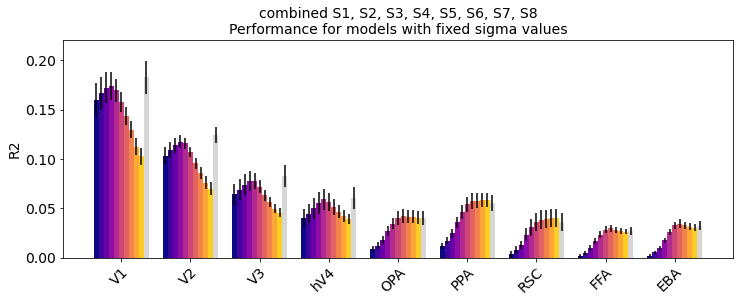

In [5]:
r2_avg = np.zeros((n_subjects, n_rois, n_sigmas))

for si in range(n_subjects):
        
    abv_thresh = summary_plots.get_noise_ceiling(out[0][si])>nc_thresh
          
    for ri in range(n_rois):

        vinds = roi_def.ss_roi_defs[si].get_indices(ri) & abv_thresh
        
        for sig_ind in range(n_sigmas):
            
            r2_vals = out[sig_ind][si]['val_r2'][:,0]

            r2_avg[si,ri,sig_ind] = np.mean(r2_vals[vinds])

vals = r2_avg

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\nPerformance for models with fixed sigma values'%(summary_plots.get_substr(out[0]))

names = ['fixed sigma=%.2f deg'%(sig*8.4) for sig in sigmas]
names += ['let sigma vary freely']

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)

colors = cm.plasma(np.linspace(0,1,n_sigmas))
colors[-1,:] = 0.8;

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 14)

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                # point_data=vals, \
                           colors=colors, space=0.1, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[0, 0.22], title=title, horizontal_line_pos=None,\
                legend_labels=names, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(12,4))

fn2save = os.path.join(default_paths.fig_path, 'textureR2_fixsigmas.pdf')
print(fn2save)
plt.savefig(fn2save)

#### define some params for plotting the unique variance

In [6]:
name1 = out[0][0]['partial_version_names'][1].split('just_')[1]
name2 = out[0][0]['partial_version_names'][2].split('just_')[1]

ve_names = ['shared', 'unique: ' + name1, 'unique: ' + name2]

gray_color = np.array([[0.6, 0.6, 0.6, 1]])

vis_color1 = np.array([[7,134,217,255]])/255
vis_color2 = np.array([[228,77,50,255]])/255

colors = np.concatenate([gray_color, vis_color1, vis_color2], axis=0)

#### Plot unique/shared variance for each sigma value (just for a few ROIs)

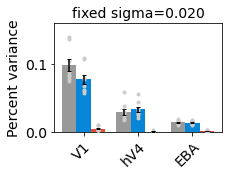

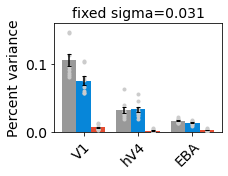

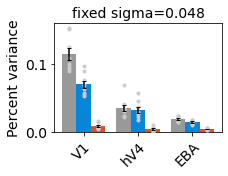

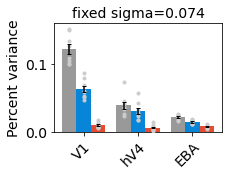

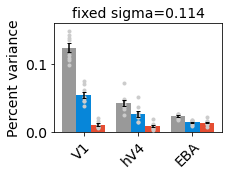

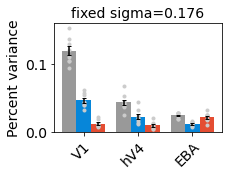

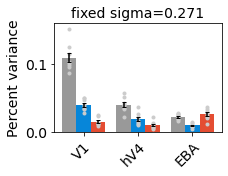

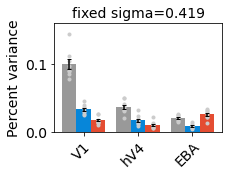

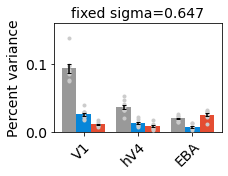

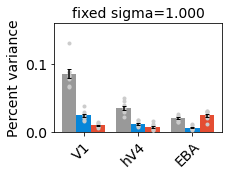

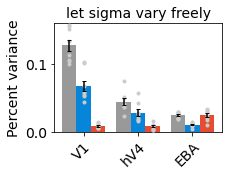

In [7]:
rois2plot = [0,3,8]

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 14)

for sig_ind in range(n_sigmas):
    
    vals = np.zeros((n_subjects, len(rois2plot), 3))
    for si, ss in enumerate(subjects):

        val_r2 = out[sig_ind][si]['val_r2']    
        r2_full = val_r2[:,0]
        r2_ll = val_r2[:,1]
        r2_hl = val_r2[:,2]

        var_expl = np.array(stats_utils.get_shared_unique_var(r2_full, r2_ll, r2_hl, \
                                                          convert_to_prop=False)).T

        # plotting only voxels with good fit for "full" model
        inds2use = val_r2[:,0] > r2_thresh 
        abv_thresh = summary_plots.get_noise_ceiling(out[0][si])>nc_thresh
        
        for ri, rr in enumerate(rois2plot):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(rr) & inds2use & abv_thresh
            
            vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)

    mean_vals = np.mean(vals, axis=0)
    sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

    legend_separate=True
    title=''

    fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                    point_data = vals, \
                               colors=colors, space=0.1, \
                                    err_capsize=2,
                    xticklabels=[roi_names[rr] for rr in rois2plot], \
                    ylabel='Percent variance', \
                    ylim=[0, 0.16], title=sig_names[sig_ind], horizontal_line_pos=None,\
                    legend_labels=np.array(ve_names), \
                    legend_overlaid=False, legend_separate=False, \
                    fig_size=(3,2))

    if sig_ind<(n_sigmas-1):
        fn2save = os.path.join(default_paths.fig_path, 'texture_lowhigh_sigma%.3f.pdf'%(sigmas[sig_ind]))
        plt.savefig(fn2save)
        

#### Plot all ROIs, just for one selected sigma value

0.002515302039682865 0.15342247486114502
/user_data/mmhender/texturemodel/figures/texture_lowhigh_sigma0.176_allareas.pdf


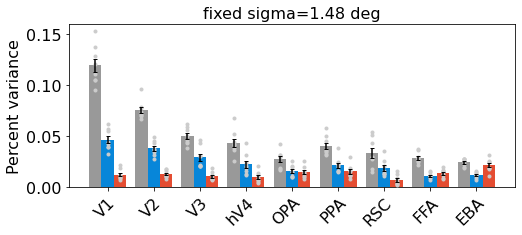

In [8]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 14)

for sig_ind in [5]:

    vals = np.zeros((n_subjects, n_rois, 3))

    for si, ss in enumerate(subjects):

        val_r2 = out[sig_ind][si]['val_r2']    
        r2_full = val_r2[:,0]
        r2_ll = val_r2[:,1]
        r2_hl = val_r2[:,2]

        var_expl = np.array(stats_utils.get_shared_unique_var(r2_full, r2_ll, r2_hl, \
                                                          convert_to_prop=False)).T
    
        # plotting only voxels with good fit for "full" model
        inds2use = val_r2[:,0] > r2_thresh 
        abv_thresh = summary_plots.get_noise_ceiling(out[0][si])>nc_thresh
        
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use & abv_thresh
            
            vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)

    mean_vals = np.mean(vals, axis=0)
    sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

    legend_separate=True
    title=''

    plt.rcParams['pdf.fonttype']=42
    plot_utils.set_all_font_sizes(fs = 16)
    print(np.min(vals), np.max(vals))
          
    fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                    point_data = vals, \
                               colors=colors, space=0.1, \
                               err_capsize=2,\
                    xticklabels=roi_names, ylabel='Percent variance', \
                    ylim=[0, 0.16], title=names[sig_ind], horizontal_line_pos=None,\
                    legend_labels=np.array(ve_names), \
                    legend_overlaid=False, legend_separate=False, \
                    fig_size=(8,3))

    if sig_ind<(n_sigmas-1):
        fn2save = os.path.join(default_paths.fig_path, 'texture_lowhigh_sigma%.3f_allareas.pdf'%(sigmas[sig_ind]))
        print(fn2save)
        plt.savefig(fn2save)
        

#### Use PyCortex to make surface plots 

In [9]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out[0][0]['partial_version_names'][pp1].split('just_')[1]
name2 = out[0][0]['partial_version_names'][pp2].split('just_')[1]



In [10]:
volumes = {}

sig_ind = 5;

for si, ss in enumerate(subjects):

    names = []
    maps = []
    cmaps = []
    mins = []
    maxes = []

    val_r2 = out[sig_ind][si]['val_r2']    
    r2_full = val_r2[:,0]
    r2_ll = val_r2[:,1]
    r2_hl = val_r2[:,2]

    var_expl = np.array(stats_utils.get_shared_unique_var(r2_full, r2_ll, r2_hl, \
                                                          convert_to_prop=False)).T
   
    ve_names = ['unique: ' + name1, 'unique: ' + name2]

    names += ['S%d %s: %s'%(ss, sig_names[sig_ind], ve_names[ve]) for ve in range(2)]
    maps += [np.sign(var_expl[:,ve]) * np.sqrt(np.abs(var_expl[:,ve])) for ve in [1,2]]
    cmaps += ['Blues', 'Reds']
    mins += [0 for ve in range(2)]
    maxes += [0.30 for ve in range(2)]

    # plotting only voxels with good fit for "full" model
    inds2use = r2_full > r2_thresh 
    abv_thresh = summary_plots.get_noise_ceiling(out[0][si])>nc_thresh

    vox2plot = inds2use & abv_thresh

    voxel_mask = out[0][si]['voxel_mask']
    nii_shape = out[0][si]['brain_nii_shape']
    mask_3d = np.reshape(voxel_mask, nii_shape, order='C')

    vol_ss = pycortex_plot_utils.maps_to_volumes(ss, maps, names, \
                         cmaps=cmaps, mins=mins, maxes=maxes, \
                         voxel_mask=voxel_mask, nii_shape=nii_shape, mask_3d=mask_3d, \
                         vox2plot=vox2plot)

    volumes.update(vol_ss)


In [11]:
viewer = pycortex_plot_utils.plot_with_overlays(volumes, title='Var part summary', \
                                                port = 44443, \
                                                labels_on=False, recache=False, \
                                                overlay_type = 'overlays_retino')

using overlays from /user_data/mmhender/pycortex_db/subj01/overlays_retino.svg
navigate browser to: 127.0.0.1:44443
Started server on port 44443
Stopping server


In [13]:
0.176*8.4


1.4784

#### Set view and save images of flatmaps

In [16]:
# load pre-made view params from a json file
# (json files are in your pycortex database folder, under subj01/views/)
viewer.get_view('subj01','flat')
viewname='flat'
# to make the view:
# viewer.save_view('subj01','flat1',True)

In [17]:
ss=2;
sig_ind=5
fn2save = os.path.join(default_paths.fig_path, \
                       'S%02d_texture_low_high_prop_sigma%.3f_%s_raw.png'%(ss,sigmas[sig_ind], viewname))
print('saving to %s'%fn2save)
viewer.getImage(fn2save, \
                size=(3000,3000))

saving to /user_data/mmhender/texturemodel/figures/S02_texture_low_high_prop_sigma0.176_flat_raw.png


[{}]

In [18]:
# cropping the images
subject_bboxes = {'subj01':[620,900,2220,2500], 'subj02':[620,900,2220,2500], \
                  'subj03': [620,800,2220,2400], 'subj04': [620,750,2220,2350], \
                  'subj05': [620,800,2220,2400], 'subj06': [620,1050,2220,2650], \
                  'subj07': [620,800,2220,2400], 'subj08': [620,900,2220,2500]}

In [19]:
import PIL
# for ss in [1]:
for ss in [1,2]:
    bbox = subject_bboxes['subj%02d'%ss]
    fn2save = os.path.join(default_paths.fig_path, \
                           'S%02d_texture_low_high_prop_sigma%.3f_%s_raw.png'%(ss,sigmas[sig_ind],viewname))
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                                   'S%02d_texture_low_high_prop_sigma%.3f_%s_cropped.png'%(ss,sigmas[sig_ind],viewname))
    im = PIL.Image.open(fn2save)
    print(im.size[0])
    if im.size[0]==3000:
        pycortex_plot_utils.crop_image(fn2save, fn2save_cropped, bbox_new=bbox)

3000
3000


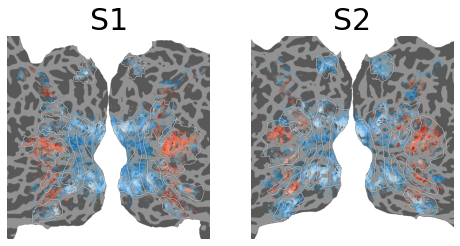

In [20]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 30)

plt.figure(figsize=(8,4))

for ss in [1,2]:
    
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                                  'S%02d_texture_low_high_prop_sigma%.3f_%s_cropped.png'%(ss,sigmas[sig_ind],viewname))
    im = PIL.Image.open(fn2save_cropped)

    plt.subplot(1,2,ss);
    plt.imshow(im)
    plt.title('S%d'%ss)
    # plt.axvline(im.size[0]/2,color='k')
    # plt.axhline(im.size[1]/2,color='k')
    plt.axis('off')
    
fn2save = os.path.join(default_paths.fig_path, 'texture_low_high_prop_fixsigma_allsubs.pdf')
plt.savefig(fn2save,dpi=1000)